# Answering Business Questions using SQL

In this project we will be playing the role of Data Analyst, using SQL to advise various business decisions for the Chinook record store.

The Chinook record store has just signed a deal with a new record label, and **we've been tasked with selecting the first three albums that will be added to the store**, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

|      Artist Name     |  Genre  |
|:--------------------:|:-------:|
| Regal                | Hip-Hop |
| Red Tone             | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites       | Blues   |

In [1]:
# Import libraries we'll use
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display graphs in notebook
%matplotlib inline

# Set graph formatting
sns.set(style='white', context='talk')
plt.style.use('dark_background')

## 1. Connecting to the database

Context managers make our life easy by taking care of opening and closing the connection to the database, as well as making sure we don't accidentally make changes to the database if one of our queries has an error.

We'll use the with statement inside a function, `run_query()`, to access the context manager that's built-in to the SQLite module. The function will return a dataframe so that we can just run our function as the last line of a Jupyter cell and it will print the results nicely for us.

We'll also create a function to run SQL queries that don't return tables, like `CREATE VIEW`. In this instance, we don't need to use pandas, we can simply use the SQLite module's `connection.execute()` method.

The `conn.isolation_level = None` line above tells SQLite to autocommit any changes.

Lastly, we'll make a function that uses our `run_query()` function to return a list of all tables and views in our databases - this is handy to quickly check the state of our database as we work

In [2]:
def run_query(q):
    """Run an sqlite3 query on the chinook database, displaying results of the query
       as a pandas dataframe.
    
    Args:
        q (str): An SQLite query in string format.
        
    Returns:
        pandas DataFrame: The result of the query.
        
    Example:
        >>>run_query("SELECT customer_id
                        FROM customer
                       LIMIT 1;
                       ")
        
        """
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
def run_command(c):
    """Run sqlite3 queries that don't return tables, like CREATE VIEW.
    
    Args:
        c (str): An SQLite query/command, in string format, that doesn't return a table.
        
    Example:
        >>>run_command("UPDATE customer_id
                        ADD COLUMN wishlist TEXT;
                       ")
        """
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
def show_tables():
    """Show a list of all tables and views in our database.
    
    Returns:
        pandas DataFrame: A list of all tables and views in the database
                          in the format of a pandas DataFrame.
    Example:
        >>>show_tables()
        	name	type
        0	album	table
        1	artist	table
        2	customer	table
        ...
        """
    q = """SELECT name,
                  type
             FROM sqlite_master
            WHERE type IN ("table","view");
            """
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## 2. Recommending albums to add to store inventory
To reiterate, the Chinook record store has just signed a deal with a new record label, and **we've been tasked with selecting the first three albums that will be added to the store**, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:


|      Artist Name     |  Genre  |
|:--------------------:|:-------:|
| Regal                | Hip-Hop |
| Red Tone             | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites       | Blues   |

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA

In [5]:
# Query that returns the number of tracks sold in the USA in absolute numbers and in percentages
query = """
/* Isolate tracks sold in the USA */
WITH sold_USA AS
        (
        SELECT il.*
          FROM invoice_line il
               INNER JOIN invoice i ON 
               i.invoice_id = il.invoice_id
               
               INNER JOIN customer c ON 
               c.customer_id = i.customer_id
         WHERE c.country = 'USA'
        )

/* Return music genres w/ number of tracks sold in the USA as numbers and percentages */
SELECT g.name AS genre,
       SUM(quantity) AS tracks_sold,
       ROUND(CAST(SUM(quantity) AS FLOAT) / (SELECT CAST(COUNT(*) AS FLOAT) 
                                               FROM sold_USA
                                            ) * 100.0, 0) AS percentage_sold
  FROM sold_USA su
       INNER JOIN track t ON 
       t.track_id = su.track_id
       
       INNER JOIN genre g ON 
       g.genre_id = t.genre_id
GROUP BY genre
ORDER BY tracks_sold DESC
LIMIT 10;
"""
genre_sales_usa = run_query(query)
genre_sales_usa

,genre,tracks_sold,percentage_sold
0,Rock,561,53.0
1,Alternative & Punk,130,12.0
2,Metal,124,12.0
3,R&B/Soul,53,5.0
4,Blues,36,3.0
5,Alternative,35,3.0
6,Latin,22,2.0
7,Pop,22,2.0
8,Hip Hop/Rap,20,2.0
9,Jazz,14,1.0


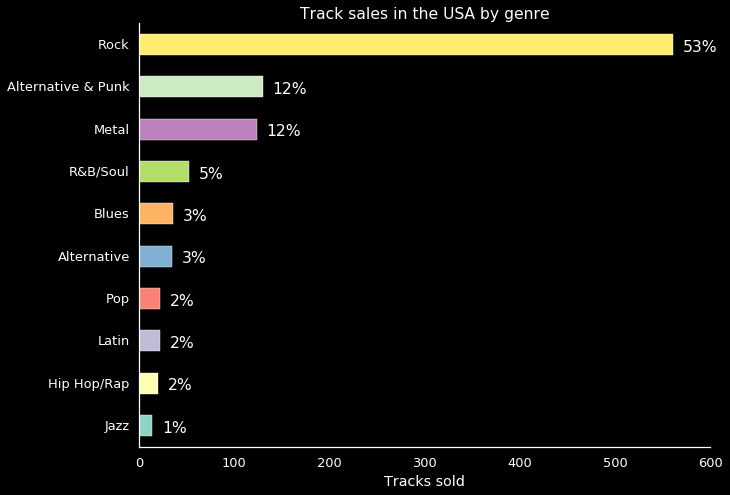

In [6]:
# Plot sales in the USA by genre
genre_sales_usa.sort_values('tracks_sold', inplace=True)
genre_sales_usa.plot.barh(x='genre', y='tracks_sold', legend=False)
plt.title('Track sales in the USA by genre')
plt.xlabel('Tracks sold')
plt.ylabel('')

# Annotate graph with respective percentages
for i, label in enumerate(list(genre_sales_usa['percentage_sold'].values)):
    score = sorted(genre_sales_usa["tracks_sold"])[i]
    label = str(int(label)) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

sns.despine()
plt.tight_layout()
plt.show()

|      Artist Name     |  Genre  |
|:---------------------|:--------|
| Regal                | Hip-Hop |
| Red Tone             | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites       | Blues   |

Based on tracks sold by genre in the USA, we would recommend purchasing albums from the following artists
* Red Tone (Punk)
* Slim Jim Bites (Blues)
* Meteor and the Girls (Pop)


These three genres only make up about 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales in the USA.

## 3. Evaluating sales performance by employee

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We have been asked to analyze the purchases of customers belonging to each employee to **see if any sales support agent is performing either better or worse than the others**.

We will consider whether any extra columns from the employee table explain any variance we see, or whether the variance might instead be indicative of employee performance.

In [7]:
# Query that returns the total dollar amount of sales assigned to each sales support agent
# within the company, as well as hire date and country.
query2 = """
/* Isolate employees with title: sales support agent */
WITH customer_support_sales AS
    (
     SELECT c.support_rep_id,
            SUM(i.total) AS total_sales
       FROM invoice i
            INNER JOIN customer c ON 
            c.customer_id = i.customer_id
      GROUP BY c.support_rep_id
    )
    
/* Return total sales of each sales support agent in descending order */
SELECT e.first_name || ' ' || e.last_name AS employee_name,
       e.hire_date,
       css.total_sales,
       e.country
  FROM customer_support_sales css
       INNER JOIN employee e ON 
       e.employee_id = css.support_rep_id
 GROUP BY employee_name
 ORDER BY css.total_sales DESC;
 """
employee_sales = run_query(query2)
employee_sales

,employee_name,hire_date,total_sales,country
0,Jane Peacock,2017-04-01 00:00:00,1731.51,Canada
1,Margaret Park,2017-05-03 00:00:00,1584.00,Canada
2,Steve Johnson,2017-10-17 00:00:00,1393.92,Canada


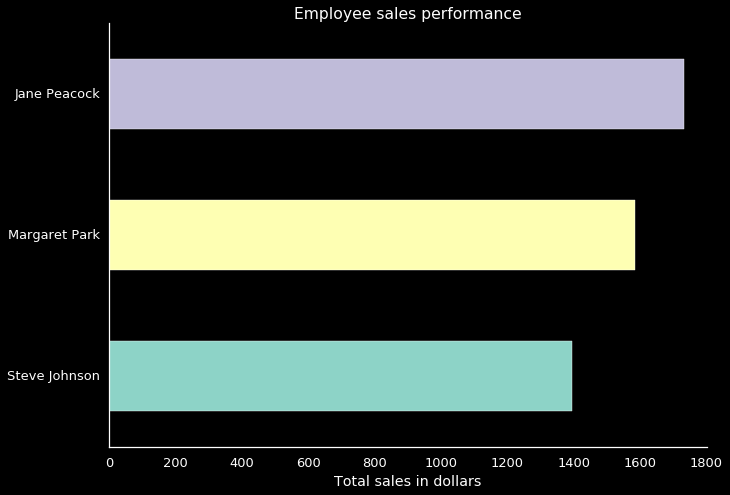

In [8]:
# Plot employee sales
employee_sales.sort_values('total_sales', inplace=True)
employee_sales.plot.barh(x='employee_name', y='total_sales', legend=False)
plt.title('Employee sales performance')
plt.xlabel('Total sales in dollars')
plt.ylabel('')
sns.despine()
plt.tight_layout()
plt.show()

Jane Peacock, who was hired first, has the most total sales amount. Meanwhile, Steve Johnson, who was hired last of the three sales reps, has the lowest total sales amount.

The total dollar amount of sales for each employee roughly corresponds to employee hire date.

## 4. Evaluating sales performance by countrys

The next task is to analyze sales data for customers from each different country.

In particular, we will look to calculate data, for each country, on the:

* Total number of customers
* Total value of sales
* Average value of sales per customers
* Average order value

We will group countries with only 1 customer as "Other" in our analysis

In [9]:
# Create a view that groups countries with only 1 customer as "Other"
command = """
/* Group countries with only 1 customer as "Other"  */
CREATE VIEW country_or_other AS
      SELECT CASE
                  WHEN (SELECT COUNT(*)
                          FROM customer 
                         WHERE country = c.country
                       ) = 1 THEN "Other"
                  ELSE c.country
              END AS country,
              c.customer_id,
              i.*
       FROM customer c
            INNER JOIN invoice i ON i.customer_id = c.customer_id;
"""
run_command(command)

OperationalError: table country_or_other already exists

In [10]:
# Query returning data on purchases from different countries
query3 = """
/* Tabulate sales data by country */
SELECT country,
       COUNT(DISTINCT customer_id) AS customers,
       ROUND(SUM(total), 2) AS total_sales,
       ROUND(SUM(total) /  COUNT(distinct customer_id), 
                                 2) AS avg_value_of_sales_per_customer,
       ROUND(SUM(total) / COUNT(distinct invoice_id), 2) AS avg_order_value
   
/* Force "Other" countries to the bottom of the table  */
  FROM (SELECT *,
               CASE
                    WHEN country = "Other" THEN 1
                    ELSE 0
                END AS sort
          FROM country_or_other
        )
 GROUP BY country
 ORDER BY sort ASC, total_sales DESC;
 """
sales_by_country = run_query(query3)
sales_by_country.set_index('country', drop=True, inplace=True)
sales_by_country

,customers,total_sales,avg_value_of_sales_per_customer,avg_order_value
country,,,,
USA,13,1040.49,80.04,7.94
Canada,8,535.59,66.95,7.05
Brazil,5,427.68,85.54,7.01
France,5,389.07,77.81,7.78
Germany,4,334.62,83.66,8.16
Czech Republic,2,273.24,136.62,9.11
United Kingdom,3,245.52,81.84,8.77
Portugal,2,185.13,92.57,6.38
India,2,183.15,91.57,8.72


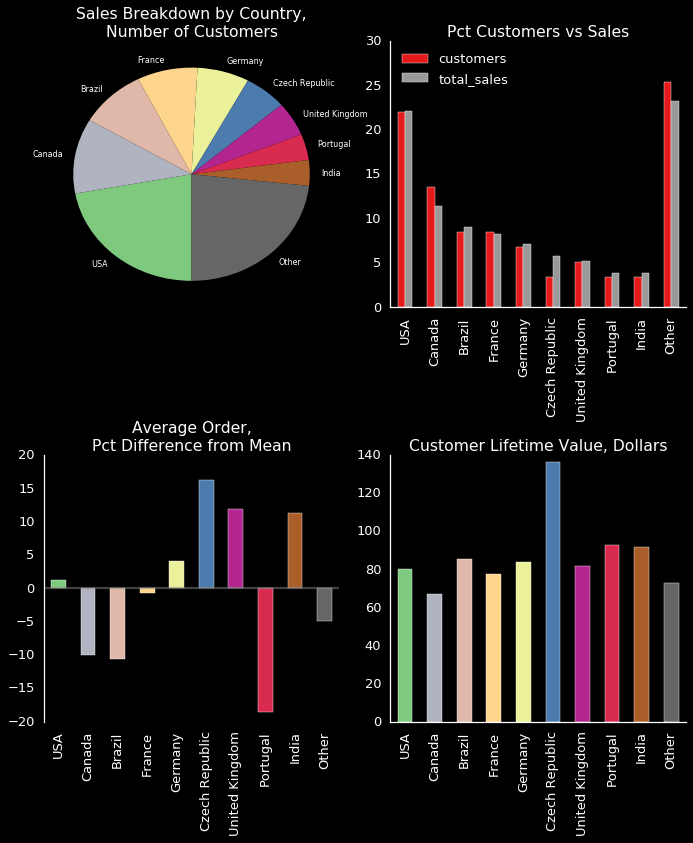

In [11]:
# Plot metrics of sales by country
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, sales_by_country.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 12))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

# top left
sales_breakdown = sales_by_country["total_sales"].copy()
sales_breakdown.plot.pie(label='', legend=False,
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers", "total_sales"]
custs_vs_dollars = sales_by_country[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in custs_vs_dollars.columns:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = sales_by_country["avg_order_value"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.plot.bar(legend=False, label='',
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off")
ax3.axhline(0, color='grey', alpha=0.5)
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = sales_by_country["avg_value_of_sales_per_customer"].copy()
ltv.index.name = ''
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

The USA leads in total sales ($1049) which also correlates with having the most customers.

Base on the average order value, it may be worth investigating sales opportunites in the following countries:

* Czech Republic
* United Kingdom
* India

These countires have higher average order values than the USA. That being said, the low number of customer data in these countries may be misleading, as it lacks the sample size to give us high confidence. However, based on this data alone, it may be worth conducting small sales campaigns in these countries to see if the trend holds using new customer data.

## 5. Recommending purchase decisions based on the percentage of individual track vs whole album purchases

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

* purchase a whole album
* purchase a collection of one or more individual tracks

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

**We have been asked to find out what percentage of purchases are individual tracks vs whole albums**, so that management can use this data to understand the effect this decision might have on overall revenue.

It is very common when performing an data analysis to have 'edge cases' which prevent getting a 100% accurate answer to a question. In this instance, we have two edge cases to consider:

* Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
* Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase

In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that the second case does not happen often, so we can ignore this case also.

In order to answer the question, we're going to have to identify whether each invoice has all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks.


In [61]:
# Query that categorizes each invoice as either an album purchase or not, calculating
# the number and percentage of invoices
query4 = """
/* Isolate album names for each invoice  */
WITH album_invoice AS
     (
      SELECT il.invoice_id,
             t.album_id  
        FROM invoice_line il
             INNER JOIN track t ON 
             t.track_id = il.track_id
       GROUP BY il.invoice_id
     ),
    
/* Compare tracks on invoice to tracks on album to decide type of purchase (album or individual track)*/
     track_vs_album_purchase AS
     (
      SELECT ai.*,
             CASE
                  WHEN (SELECT il.track_id
                          FROM invoice_line il
                         WHERE il.invoice_id = ai.invoice_id
                        EXCEPT
                        SELECT t.track_id
                          FROM track t
                         WHERE t.album_id = ai.album_id
                       ) IS NULL              -- Null means all tracks in the album are in the invoice.
                   AND
                       (SELECT t.track_id
                          FROM track t
                         WHERE t.album_id = ai.album_id
                        EXCEPT
                        SELECT il.track_id
                          FROM invoice_line il
                         WHERE il.invoice_id = ai.invoice_id
                       ) IS NULL            -- Need to combine with reverse variation.
                                            -- Null means all tracks in the invoice are in the album.
                  THEN 'Album'
                  ELSE 'Individual Track'  -- If either case is NOT NULL, then it's an individual track.
              END AS purchase_type
         FROM album_invoice ai
     )

/* Groups the number/percentage of invoices by purchase type (album or individual track)*/        
SELECT purchase_type,
       COUNT(*) AS number_of_invoices,
       ROUND(COUNT(*) * 100 / (SELECT COUNT(*)
                                 FROM invoice), 0) AS percentage_of_invoices
  FROM track_vs_album_purchase
 GROUP BY purchase_type
 ORDER BY number_of_invoices DESC;
 """

album_vs_tracks = run_query(query4)
album_vs_tracks

,purchase_type,number_of_invoices,percentage_of_invoices
0,Individual Track,500,81.0
1,Album,114,18.0


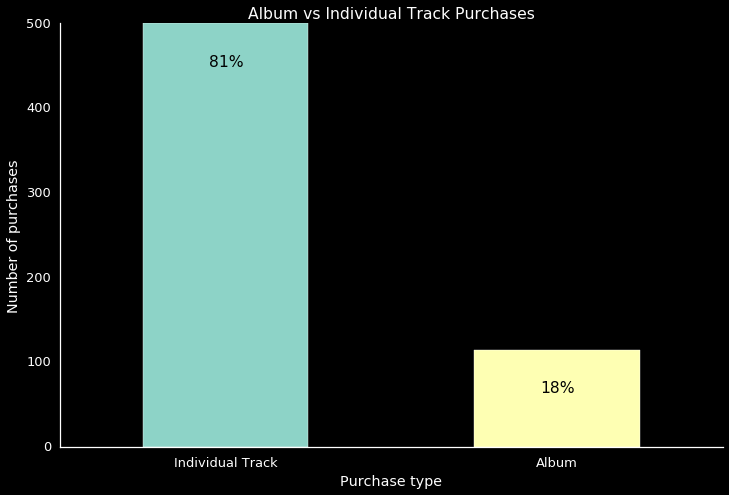

In [79]:
# PLot album vs individual track purchases
album_vs_tracks.plot.bar(x='purchase_type', y='number_of_invoices', legend = False)
plt.title('Album vs Individual Track Purchases')
plt.xticks(rotation=0)
plt.xlabel('Purchase type')
plt.ylabel('Number of purchases')

# Annotate graph with respective percentages
for i, label in enumerate(list(album_vs_tracks['percentage_of_invoices'].values)):
    score = album_vs_tracks["number_of_invoices"][i]
    label = str(int(label)) + "%"
    plt.annotate(str(label), (i - 0.05, score - 50), color='black')

sns.despine()
plt.tight_layout()
plt.show();

A great majority of purchases, 81%, are individual tracks. Meanwhile, 18% of purchases are whole albums.

The Chinook record store is consdering purchasing only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

Given the data, the store could potentially be missing out on just over a fifth of it's total revenue if they decide to go with this purchasing strategy.

## 6. The most popular musicians on playlists
Which artists are the most used in playlists? Can we use this metric to make business decisions? Lets see.

In [13]:
# Query returning the top 5 artists with the most distinct playlist appearances
query5 = """
/* Counts the number of playlists an artist appears on and displays the top 5  */
SELECT ar.name AS artist,
       g.name AS genre,
       COUNT(DISTINCT pt.playlist_id) AS number_of_playlists_appeared_on
  FROM track t
       INNER JOIN playlist_track pt ON
       pt.track_id = t.track_id
       
       INNER JOIN genre g ON 
       g.genre_id = t.genre_id
       
       INNER JOIN album al ON 
       al.album_id = t.album_id
       
       INNER JOIN artist ar ON 
       ar.artist_id = al.artist_id
 GROUP BY artist
 ORDER BY number_of_playlists_appeared_on DESC
 LIMIT 5;
 """
artists_on_playlists = run_query(query5)
artists_on_playlists

,artist,genre,number_of_playlists_appeared_on
0,Eugene Ormandy,Classical,7
1,Academy of St. Martin in the Fields & Sir Nevi...,Classical,6
2,Berliner Philharmoniker & Herbert Von Karajan,Classical,6
3,English Concert & Trevor Pinnock,Classical,6
4,The King's Singers,Classical,6


Here are the top 5 artists used in the most playlists. All 5 belong to the classical music genre, which, if we look at an earlier analysis of genres, make up less than 0.4% of sales in the USA (the country with the most sales).

Therefore, the number of playlist appearances for an artist is not a good indicator to base purchase strategies off of for the Chinook record store.

## 7. Tracks sold by artist

A better indicator would be the number of artist sales by looking at the number of times an artist appears on an invoice.

In [14]:
# Query returning the top 10 selling artists
query6 = """
/* Isolate top 10 artists with most tracks sold  */
SELECT ar.name AS artist,
       g.name AS genre,
       SUM(il.quantity) AS tracks_sold
  FROM track t
       INNER JOIN invoice_line il ON 
       il.track_id = t.track_id
       
       INNER JOIN genre g ON 
       g.genre_id = t.genre_id
       
       INNER JOIN album al ON
       al.album_id = t.album_id
       
       INNER JOIN artist ar ON 
       ar.artist_id = al.artist_id
       
 GROUP BY artist
 ORDER BY tracks_sold DESC
 LIMIT 10;
 """
tracks_sold_by_artist = run_query(query6)
tracks_sold_by_artist.set_index('artist', drop=True, inplace=True)
tracks_sold_by_artist

,genre,tracks_sold
artist,,
Queen,Rock,192
Jimi Hendrix,Rock,187
Nirvana,Rock,130
Red Hot Chili Peppers,Rock,130
Pearl Jam,Rock,129
AC/DC,Rock,124
Guns N' Roses,Metal,124
Foo Fighters,Rock,121
The Rolling Stones,Rock,117


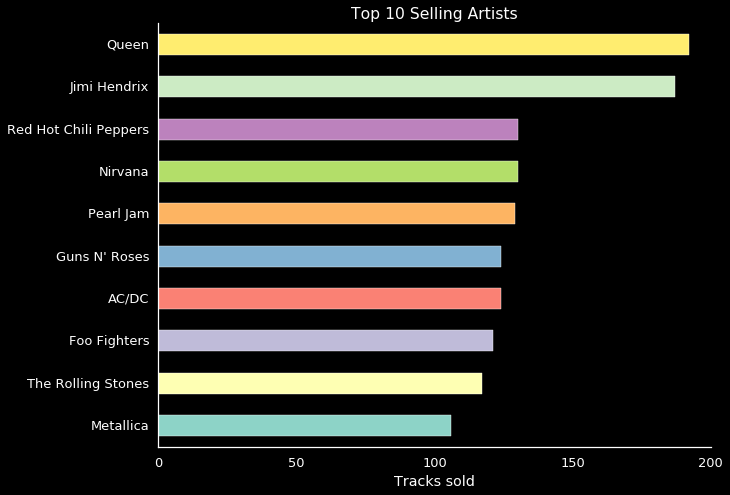

In [15]:
# Plot tracks sold by artist
tracks_sold_by_artist.sort_values('tracks_sold', inplace=True)
tracks_sold_by_artist.plot.barh(y='tracks_sold', legend=False)
plt.title('Top 10 Selling Artists')
plt.xlabel('Tracks sold')
plt.ylabel('')
sns.despine()
plt.tight_layout()
plt.show()

Here we have the top 10 sold artists. These artists are a safe bet when the store is making purchasing decisions, as they have the most sold tracks.

## 8. Tracks sold vs not sold
How many tracks have been purchased vs not purchased?

In [81]:
# Query returning the number of tracks purchased vs unpurchased, both as an absolute number and
# as a percentage of inventory.
query7 = """
/* Categorize tracks found in invoices as "purchased," and those not as "not purchased"*/
WITH purchased_vs_not_purchased AS
     (
      SELECT *,
             CASE 
                  WHEN (SELECT il.track_id
                          FROM invoice_line il
                         WHERE il.track_id = t.track_id) IS NOT NULL
                  THEN "Purchased"
                  ELSE "Not Purchased"
              END AS purchase_status
        FROM track t
     )
    
/* Count the number of puchased/unpurchased tracks */
SELECT purchase_status,
       COUNT(*) AS number_of_tracks,
       ROUND(CAST(COUNT(*) AS FLOAT) * 100 / (SELECT COUNT(*)
                                                FROM purchased_vs_not_purchased
                                             ), 0) AS percentage_of_inventory
  FROM purchased_vs_not_purchased
 GROUP BY purchase_status
 ORDER BY number_of_tracks DESC;
 """

tracks_sold = run_query(query7)
tracks_sold

,purchase_status,number_of_tracks,percentage_of_inventory
0,Purchased,1806,52.0
1,Not Purchased,1697,48.0


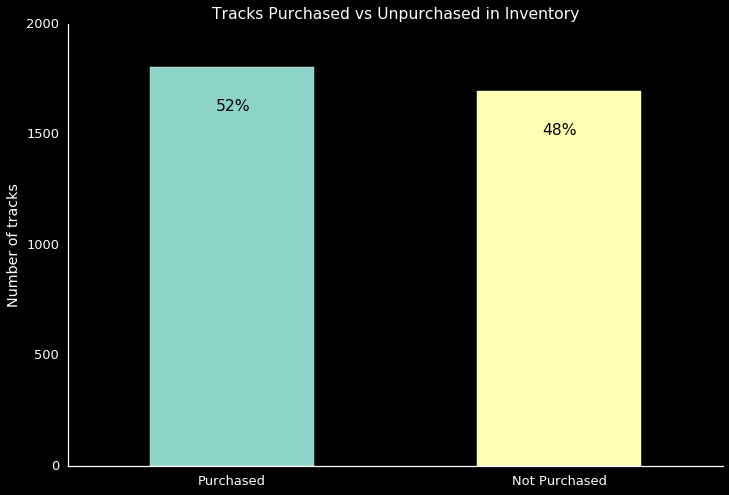

In [85]:
# Plot tracks purchased vs not purchased
tracks_sold.plot.bar(x='purchase_status', y='number_of_tracks', legend=False)
plt.title('Tracks Purchased vs Unpurchased in Inventory')
plt.xticks(rotation=0)
plt.xlabel('')
plt.ylabel('Number of tracks')

# Annotate graph with respective percentages
for i, label in enumerate(list(tracks_sold['percentage_of_inventory'].values)):
    score = tracks_sold["number_of_tracks"][i]
    label = str(int(label)) + "%"
    plt.annotate(str(label), (i - 0.05, score - 200), color='black')

sns.despine()
plt.tight_layout()
plt.show();

Roughly half of of the Chinook Record Store inventory has not been purchased. Though magical moments come from finding that one record no one else has, the store may want to revise its purchasing decisions. 

Perhaps developing campaigns to market these unsold tracks is a good idea since idle inventory is lost revenue. A revision of purchasing decisions is also worthwhile so as too avoid such a large amount of sitting inventory.

### 8.1 Unsold tracks by genre

In [29]:
# Query returning the top 10 number and percentage of unsold tracks by genre.
query8 = """
/* Categorize tracks found in invoices as "purchased," and those not as "not purchased"*/
WITH purchased_vs_not_purchased AS
     (
      SELECT *,
             g.name AS genre,
             CASE 
                  WHEN (SELECT DISTINCT il.track_id
                          FROM invoice_line il
                         WHERE il.track_id = t.track_id
                       ) IS NOT NULL
                  THEN "Purchased"
                  ELSE "Not Purchased"
              END AS purchase_status
        FROM track t
             INNER JOIN genre g ON 
             g.genre_id = t.genre_id
     )

/* Count the number of unpurchased tracks by genre, displaying the top 8 */
SELECT genre,
       COUNT(DISTINCT track_id) AS number_of_unsold_tracks,
       ROUND(CAST(COUNT(DISTINCT track_id) AS FLOAT) / (SELECT COUNT(DISTINCT track_id)
                                                          FROM purchased_vs_not_purchased
                                                         WHERE purchase_status = "Not Purchased"
                                                        ) * 100, 0) AS percentage_of_unsold_tracks
  FROM purchased_vs_not_purchased
 WHERE purchase_status = "Not Purchased"
 GROUP BY genre
 ORDER BY number_of_unsold_tracks DESC
 LIMIT 10;
 """

unsold_genres = run_query(query8)
unsold_genres

,genre,number_of_unsold_tracks,percentage_of_unsold_tracks
0,Latin,460,27.0
1,Rock,382,23.0
2,Alternative & Punk,156,9.0
3,Metal,136,8.0
4,TV Shows,91,5.0
5,Jazz,69,4.0
6,Drama,63,4.0
7,Classical,58,3.0
8,Soundtrack,38,2.0
9,Reggae,36,2.0


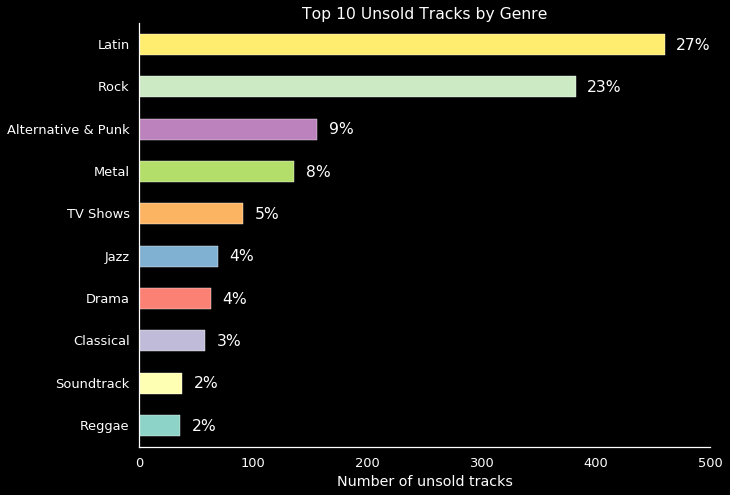

In [25]:
# Plot unsold tracks by genre
unsold_genres.sort_values('number_of_unsold_tracks', inplace=True)
unsold_genres.plot.barh(x='genre', y='number_of_unsold_tracks', legend=False)
plt.title('Top 10 Unsold Tracks by Genre')
plt.xlabel('Number of unsold tracks')
plt.ylabel('')

# Annotate graph with respective percentages
for i, label in enumerate(list(unsold_genres['percentage_of_unsold_tracks'].values)):
    score = sorted(unsold_genres["number_of_unsold_tracks"])[i]
    label = str(int(label)) + "%"
    plt.annotate(str(label), (score + 10, i - 0.1))

sns.despine()
plt.tight_layout()
plt.show()

The Latin and Rock genres each make up about a quarter of unsold tracks. From a previous analysis, we see the Latin genre makes up only about 2% of sales while the rock genre makes up for roughly 50% of sales.

Given the majority of sales, perhaps it's only a matter of time before these unsold rock tracks are bought (or maybe the tracks/artists just aren't as popular). 

Focusing on developing marketing strategies to sell these Latin tracks to the Latin community in both the USA (the leading country in sales) and globally could prove beneficial, as there are virtually no sales in Spanish speaking countries.

Given such a large share of unsold tracks, it may be worth comparing the track inventory to sales popularity...

## 9. Store inventory vs sales popularity
Is the range of tracks in the store reflective of their sales popularity?

In [35]:
# Query returning the top 12 percentages of inventory and their percentages of sales by genre
query9 = """
/* Show the proportion of inventory and sales by genre */
SELECT g.name AS genre,
       COUNT(DISTINCT t.track_id) AS tracks_in_inventory,
       ROUND(CAST(COUNT(DISTINCT t.track_id) AS FLOAT) * 100 / (SELECT COUNT(DISTINCT track_id) 
                                                                  FROM track
                                                               ), 2) AS pct_of_inventory,
       ROUND(CAST(SUM(il.quantity) AS FLOAT) * 100 / (SELECT COUNT(*)
                                                     FROM invoice_line
                                                  ), 0) AS pct_of_sales
  FROM track t
       INNER JOIN genre g ON 
       g.genre_id = t.genre_id
       
       LEFT JOIN invoice_line il ON 
       il.track_id = t.track_id
 GROUP BY genre
 ORDER BY tracks_in_inventory DESC
 LIMIT 12;
 """

inventory_vs_popularity = run_query(query9)
inventory_vs_popularity.set_index('genre', drop=True, inplace=True)
inventory_vs_popularity

,tracks_in_inventory,pct_of_inventory,pct_of_sales
genre,,,
Rock,1297,37.03,55.0
Latin,579,16.53,4.0
Metal,374,10.68,13.0
Alternative & Punk,332,9.48,10.0
Jazz,130,3.71,3.0
TV Shows,93,2.65,0.0
Blues,81,2.31,3.0
Classical,74,2.11,1.0
Drama,64,1.83,0.0


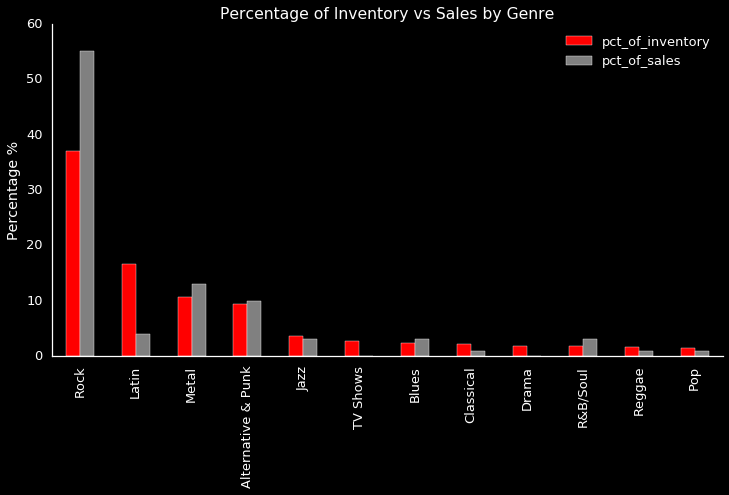

In [43]:
# Plot the top percentages of inventory and sales by genre.
cols = ["pct_of_inventory", "pct_of_sales"]
inventory_vs_sales = inventory_vs_popularity[cols].copy()
inventory_vs_sales.index.name = ''
inventory_vs_sales.plot.bar(color=['red','grey'])
plt.title('Percentage of Inventory vs Sales by Genre')
plt.ylabel('Percentage %')
sns.despine()
plt.tight_layout()
plt.show()

Inventory more or less follows the trend of sales popularity, with the exception of tracks in the Latin genre. Latin tracks make up about one sixth of the store's inventory but less than 4% of sales. 

This reinforces the idea of focusing on a Latin music marketing campaign.

## 10. Protected vs non-protected media types
Do protected vs non-protected media types have an effect on track popularity?

In [44]:
# Query returning all unique media types.
query10 = """
/* Show all media types */
SELECT DISTINCT name AS media_types
  FROM media_type;
"""
media_types = run_query(query10)
media_types

,media_types
0,MPEG audio file
1,Protected AAC audio file
2,Protected MPEG-4 video file
3,Purchased AAC audio file
4,AAC audio file


Tracks come in 5 media types. Only 2 are protected.

In [45]:
# Query returning the proportion of sales by protected vs non-protected media types.
query11 = """
/* Group tracks into protected and non-protected categories */
WITH protection AS
     (
      SELECT *,
             CASE
                  WHEN mt.name LIKE "%Protected%"
                  THEN "Protected"
                  ELSE "Non-protected"
              END AS protection_status
         FROM track t
              INNER JOIN media_type mt ON mt.media_type_id = t.media_type_id
     )

/* Show the proportion of sales by protected vs non-protected type */
SELECT protection_status,
       SUM(il.quantity) tracks_sold,
       ROUND(CAST(SUM(il.quantity) AS FLOAT) * 100 / (SELECT COUNT(*)
                                                        FROM invoice_line
                                                     ), 0) percentage_sold
  FROM protection p
       LEFT JOIN invoice_line il ON il.track_id = p.track_id
 GROUP BY 1
 ORDER BY 2 DESC;
 """

protected_vs_nonprotected = run_query(query11)
protected_vs_nonprotected

,protection_status,tracks_sold,percentage_sold
0,Non-protected,4315,91.0
1,Protected,442,9.0


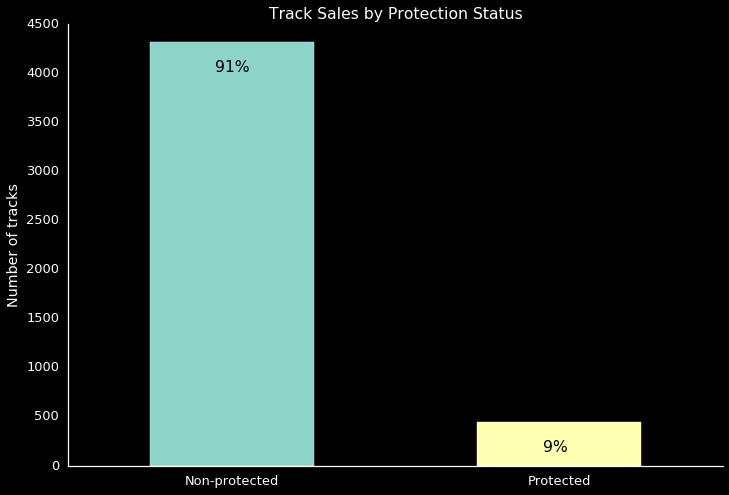

In [87]:

# Plot track sales by protection status
protected_vs_nonprotected.plot.bar(x='protection_status', y='tracks_sold', legend=False)
plt.title('Track Sales by Protection Status')
plt.xticks(rotation=0)
plt.xlabel('')
plt.ylabel('Number of tracks')

# Annotate graph with respective percentages
for i, label in enumerate(list(protected_vs_nonprotected['percentage_sold'].values)):
    score = protected_vs_nonprotected["tracks_sold"][i]
    label = str(int(label)) + "%"
    plt.annotate(str(label), (i - 0.05, score - 300), color='black')

sns.despine()
plt.tight_layout()
plt.show();

Non-protected tracks make up over 90% of sales, making them the most popular. When making purchase decisions, it's prot best to avoid protected formats unless it's the only format available for a desired track.

The numbers make sense, since protected formats usually come with sharing and playback restrictions. Restrictions are typically undesirable when it comes to music and entertainment.

## Conclusion
We played the role of data analyst and utilized SQL to advise on various business decisions for the Chinook record store and gained the following insights:
* **Rock is our most sold music genre in the USA and in general**, making up 53% of sales in the USA and 55% of sales globally.
* For the record label partnership, based on tracks sold by genre in the USA, we would **recommend purchasing albums from** the following artists:
    * **Red Tone** (Punk)
    * **Slim Jim Bites** (Blues)
    * **Meteor and the Girls** (Pop)
* Sales Support Agent **employee rankings based on sales**:
    1. **Jane Peakcock**
    2. **Margaret Park**
    3. **Steve Johnson**
        - The difference in sales performance correlates with hire date, with those with an earlier hire date having greater sales numbers
* **The USA and Canada lead our total sales**. Sales figures correlate with the number of customers.
* Based on country average order value, **it may be worth investigating sales opportunites in India, Czech Republic, and the United Kingdom**, though more data is needed to substantiate additional putting forth additinoal rescources towards these markets
* Indiviudal tracks make up 81% of purchases, while whole albums make up the rest. **It's not advised for the store to drop album purchases, as they make up about a fifth of our revenue**
* Eugene Ormandy has the most playlist appearances, followed by other classical musicians. **The number of playlist appearances is not indicative of popularity**, however, as classical music ranks amongst the lowest in sales.
* Queen, Jimi Hendrix, Nirvana, and Red Hot Chili Peppers are the **top 4 selling artists**.
* **48% of the store's inventory remains unpurchased**. Perhaps a revisision of purchasing decisions is in order.
* **Latin music makes up about one sixth of the store's inventory but less than 4% of sales**. It also makes up over a quarter of unsold inventory. We advise focusing on developing marketing strategies to sell these Latin tracks to the Latin community in both the USA (the leading country in sales) and globally, as there are virtually no sales in Spanish speaking countries.
* **Non-protected media is the most popular type of media**, making up 91% of tracks sold. We advise avoiding protected formats unless it's the only format available for a desired track.